In [1]:
import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

# import all needed libraries
import sys
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/algo')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/commons')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/')
from trading.alg_order import AlgOrderFake
from trading.trading_pair import TradingPair
from trading.trading_api import TradingApi
from trading.trading_api_fake import TradingApiFake
from trading.trading_module import TradingModule
from ml.utils_ml import remove_id_index, format_both_close_prices, format_close_prices, save_obj, load_obj
from trading.backtesting_strategy import BacktestingStrategy

from ml.preproc_prepare import *
from ml.preproc_learning import *

[BUY] ORDER PLACED (2018-10-14 01:00:00+00:00): 2380.2716225875624 XRP for 1000.0$ (close_price = 0.42$ / fees = 1.0)
[SELL] ORDER PLACED (2018-10-18 01:00:00+00:00): 2380.2716225875624 XRP for 1139.961113652609$ (close_price = 0.48$ / fees = 1.14)
[BUY] ORDER PLACED (2018-11-17 22:00:00+00:00): 2307.1741339930236 XRP for 1139.961113652609$ (close_price = 0.49$ / fees = 1.14)
[SELL] ORDER PLACED (2018-11-18 23:00:00+00:00): 2307.1741339930236 XRP for 1164.1883014247962$ (close_price = 0.51$ / fees = 1.17)
[BUY] ORDER PLACED (2018-11-24 23:00:00+00:00): 39.85689215638696 LTC for 1164.1883014247962$ (close_price = 29.18$ / fees = 1.16)
[SELL] ORDER PLACED (2018-11-26 01:00:00+00:00): 39.85689215638696 LTC for 1248.8613110625922$ (close_price = 31.36$ / fees = 1.25)
[BUY] ORDER PLACED (2018-11-27 18:00:00+00:00): 11.647954903851456 ETH for 1248.8613110625922$ (close_price = 107.11$ / fees = 1.25)
[SELL] ORDER PLACED (2018-11-28 19:00:00+00:00): 11.647954903851456 ETH for 1448.603852074487

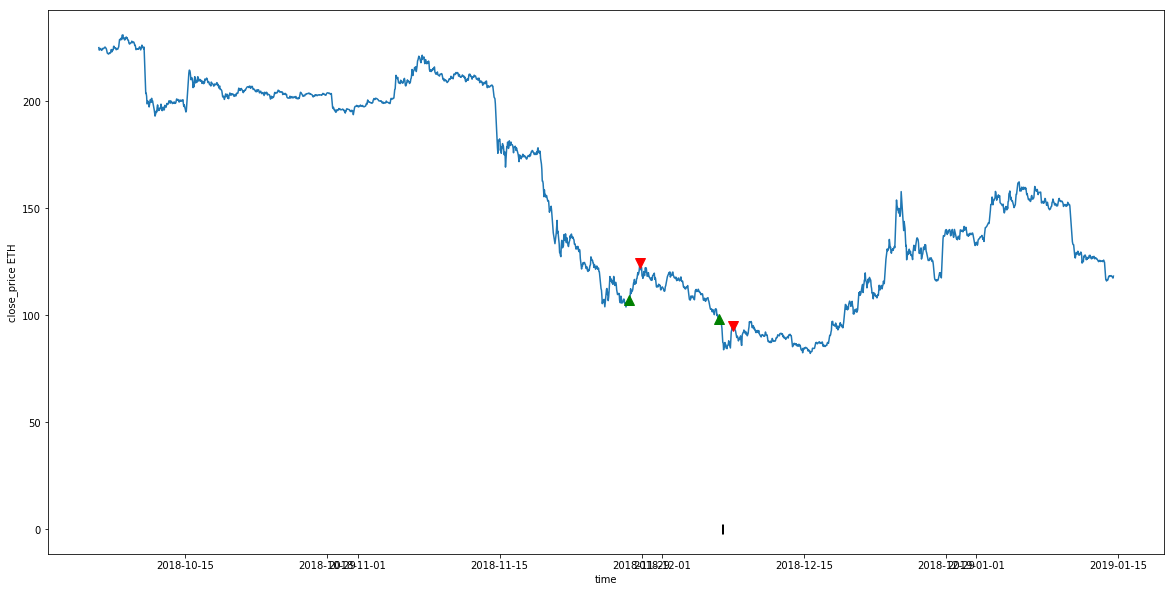

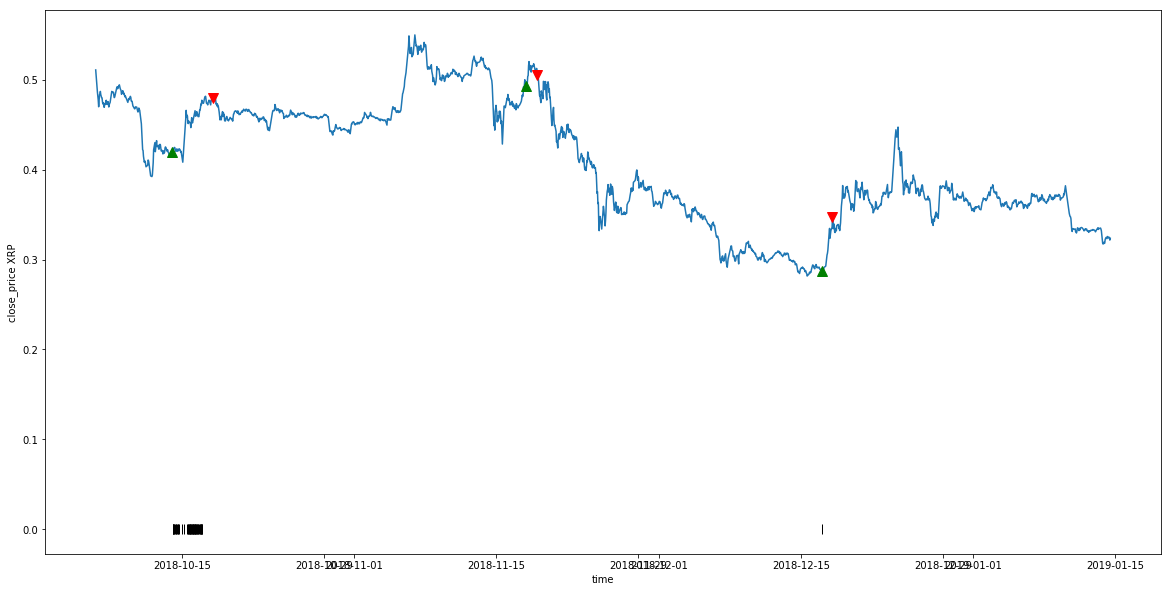

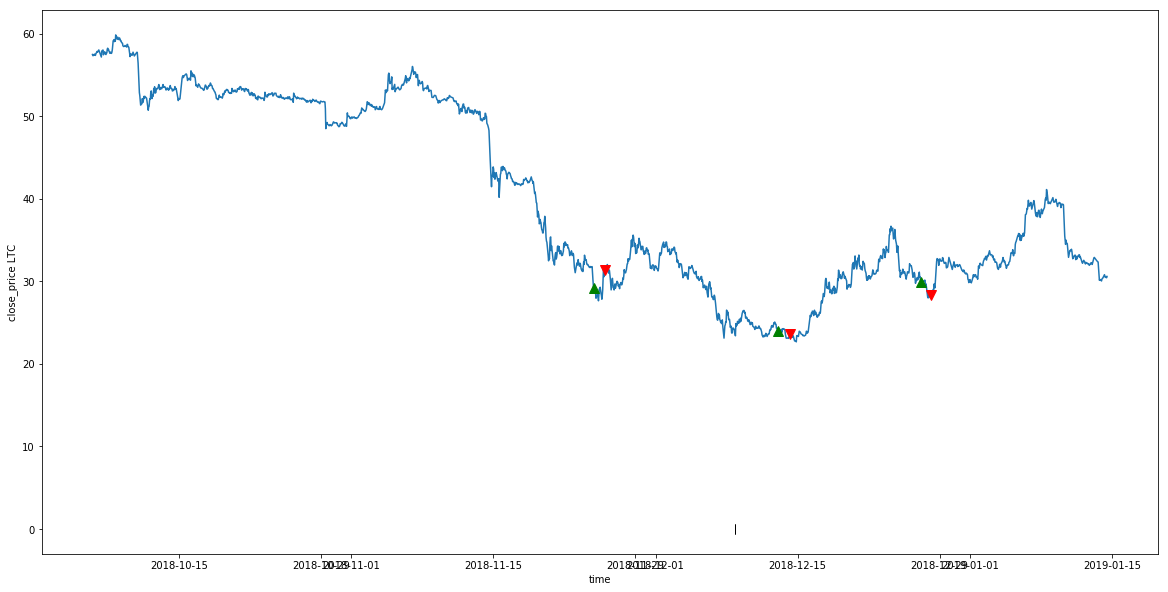

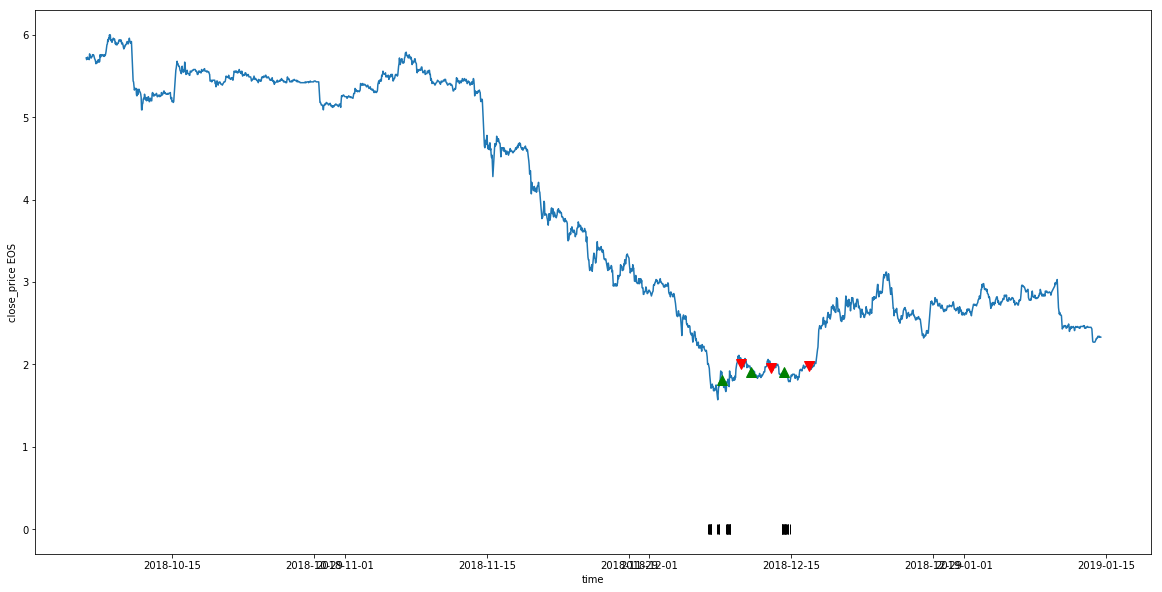

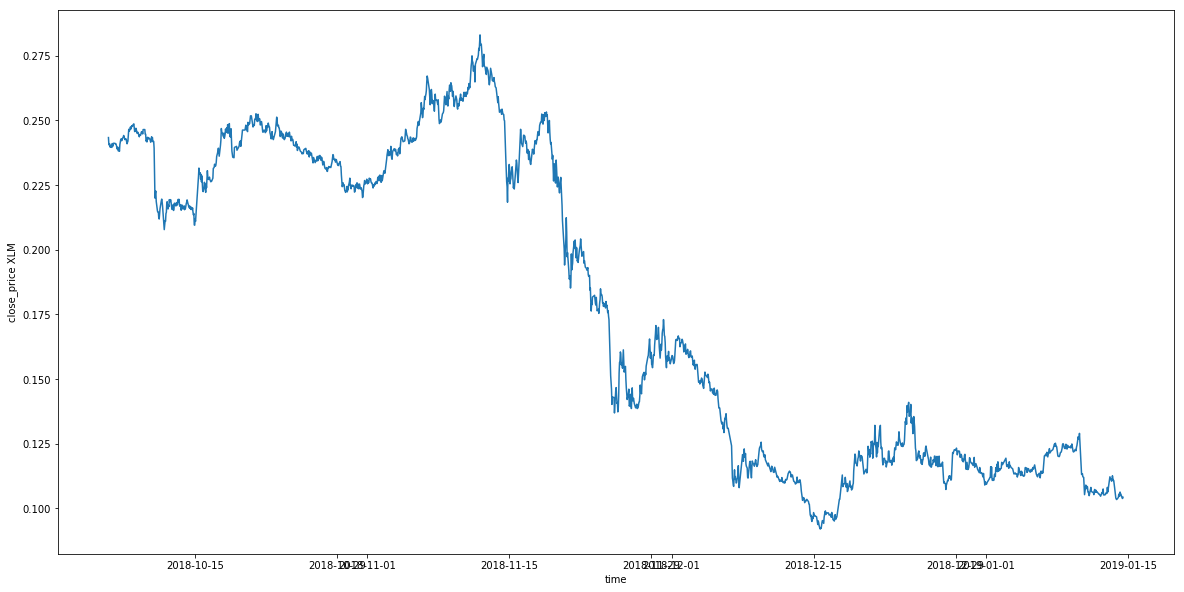

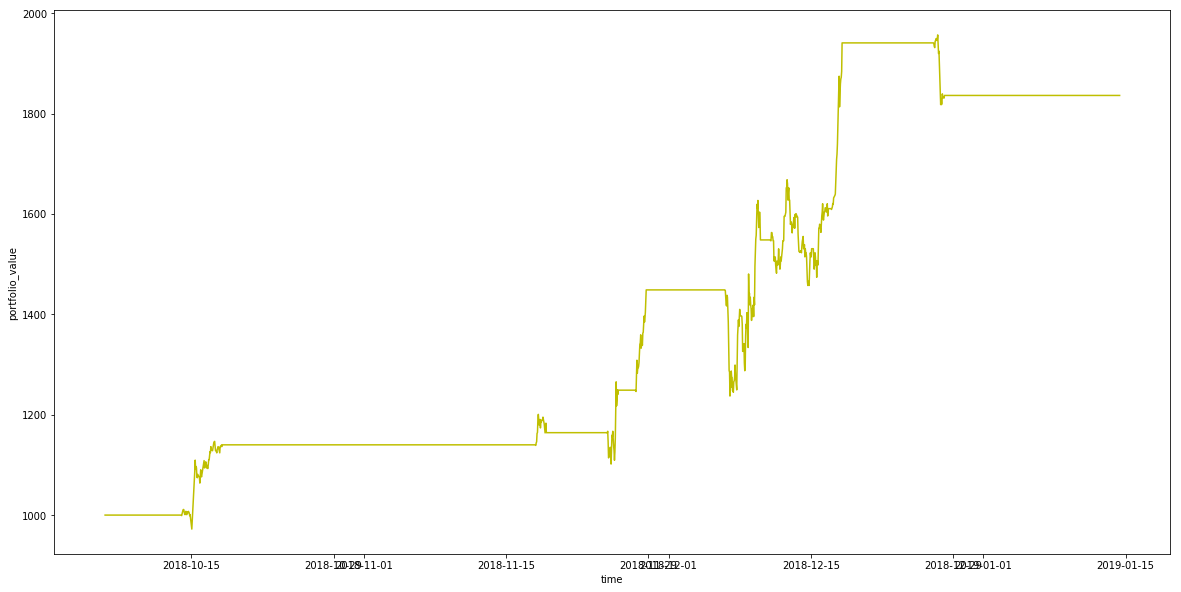

In [7]:
# Testing set
threshold = 0.78
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = TradingPair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = TradingPair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'LTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = TradingPair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = TradingPair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = TradingPair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_test_1.index.get_level_values(0).min()
end_date = y_test_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_test_1, trading_pair_2: X_test_2, trading_pair_3: X_test_3, trading_pair_4: X_test_4, trading_pair_5: X_test_5}
X_closes = {trading_pair_1: X_test_close_price_1, trading_pair_2: X_test_close_price_2, trading_pair_3: X_test_close_price_3, trading_pair_4: X_test_close_price_4, trading_pair_5: X_test_close_price_5}

model_1 = load_obj('production_model')
backtest = BacktestingStrategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

[BUY] ORDER PLACED (2017-12-07 16:00:00+00:00): 2.3985594237695076 ETH for 1000.0$ (close_price = 416.5$ / fees = 1.0)
[SELL] ORDER PLACED (2017-12-09 17:00:00+00:00): 2.3985594237695076 ETH for 1149.6156825306123$ (close_price = 479.77$ / fees = 1.15)
[BUY] ORDER PLACED (2017-12-10 07:00:00+00:00): 2.6231466512449906 ETH for 1149.6156825306123$ (close_price = 437.82$ / fees = 1.15)
[SELL] ORDER PLACED (2017-12-21 09:00:00+00:00): 2.6231466512449906 ETH for 2175.47999780859$ (close_price = 830.17$ / fees = 2.18)
[BUY] ORDER PLACED (2017-12-22 15:00:00+00:00): 292.8981829933668 EOS for 2175.47999780859$ (close_price = 7.42$ / fees = 2.18)
[SELL] ORDER PLACED (2017-12-27 13:00:00+00:00): 292.8981829933668 EOS for 2583.7046648755972$ (close_price = 8.83$ / fees = 2.59)
[BUY] ORDER PLACED (2017-12-28 06:00:00+00:00): 324.26142716215094 EOS for 2583.7046648755972$ (close_price = 7.96$ / fees = 2.58)
[SELL] ORDER PLACED (2018-01-07 15:00:00+00:00): 324.26142716215094 EOS for 3232.89291403518

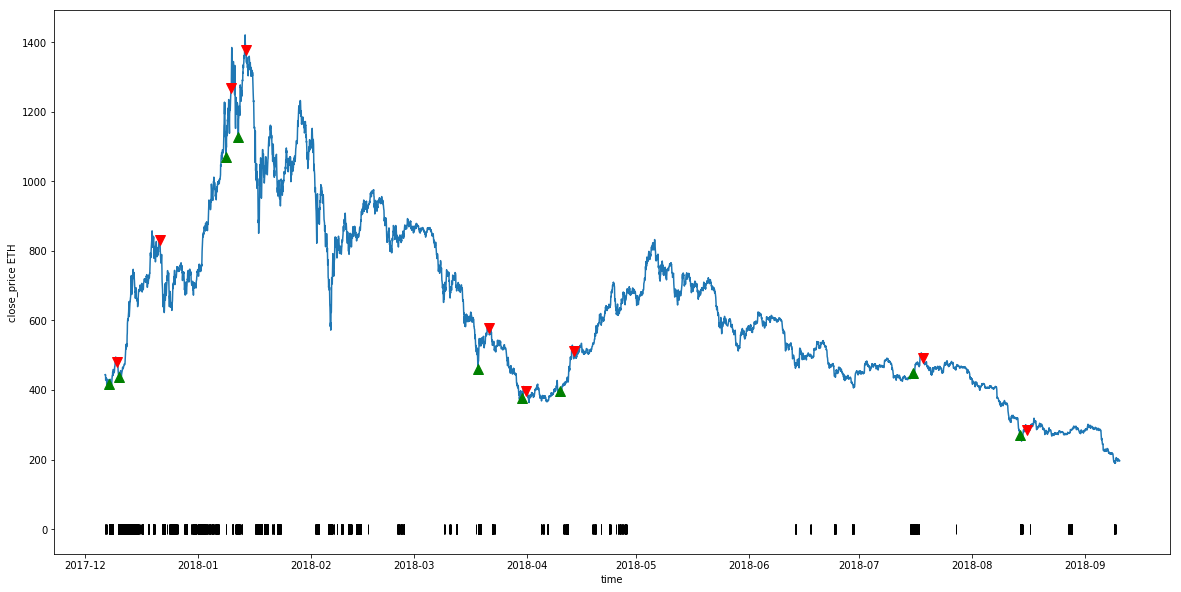

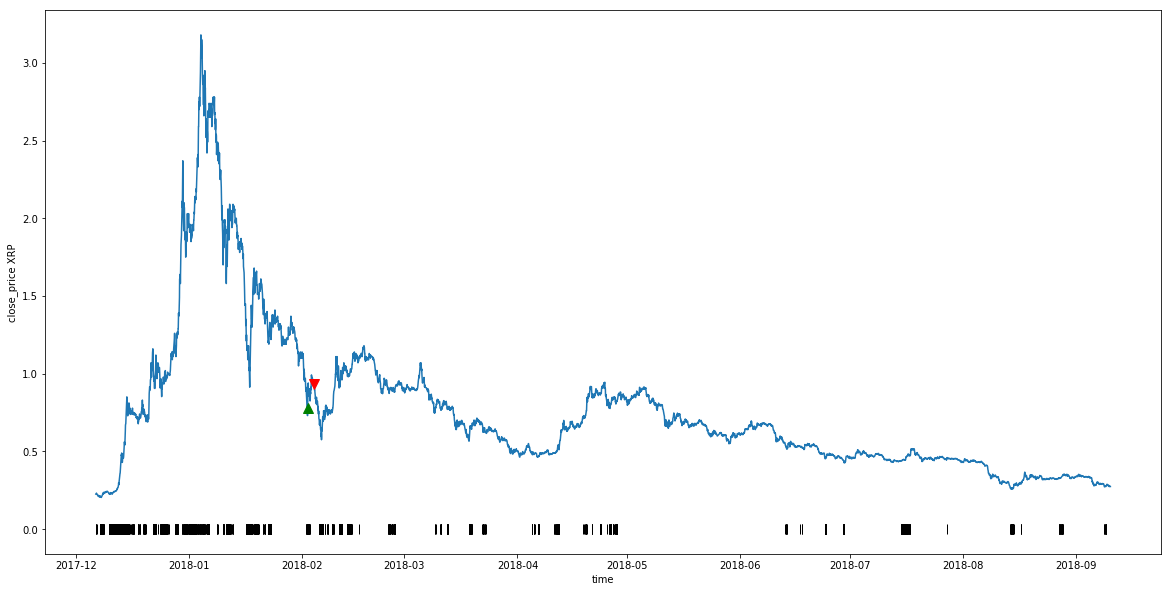

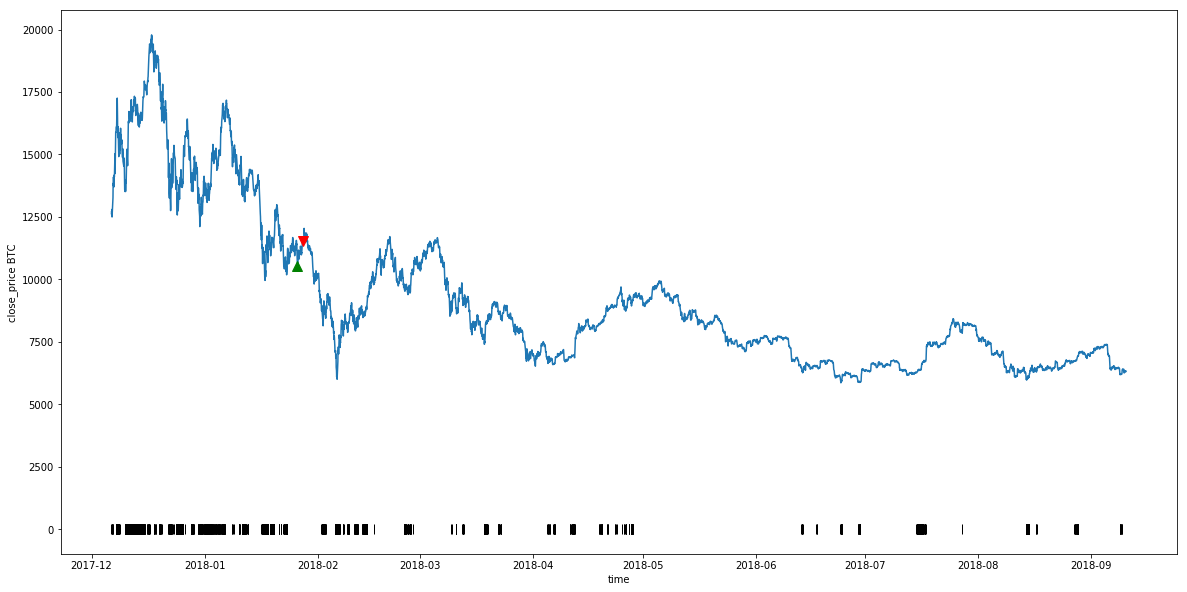

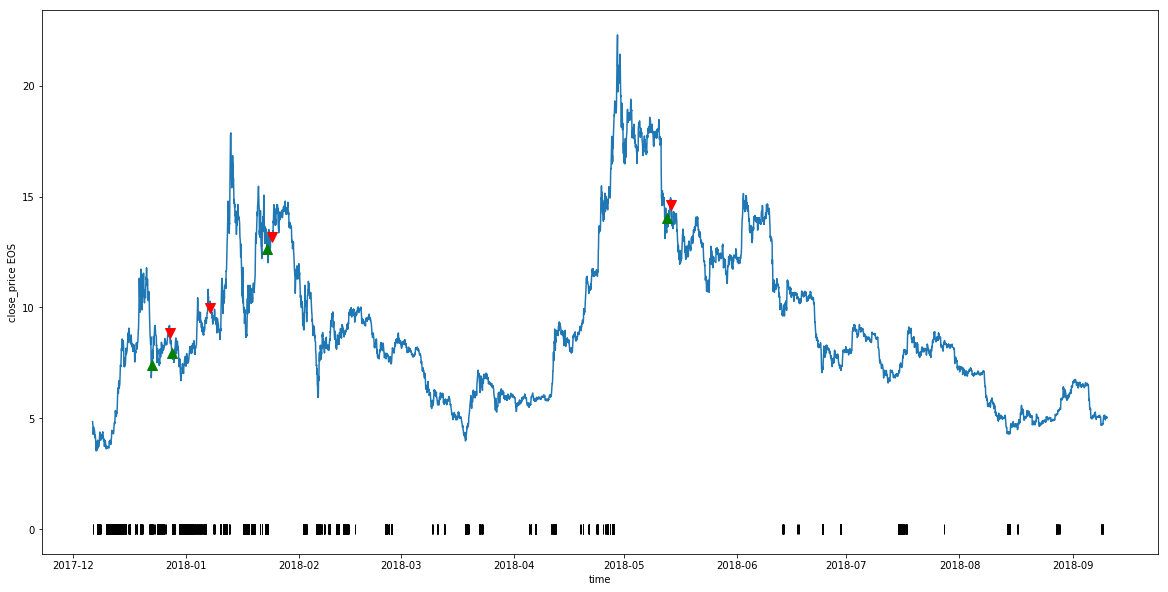

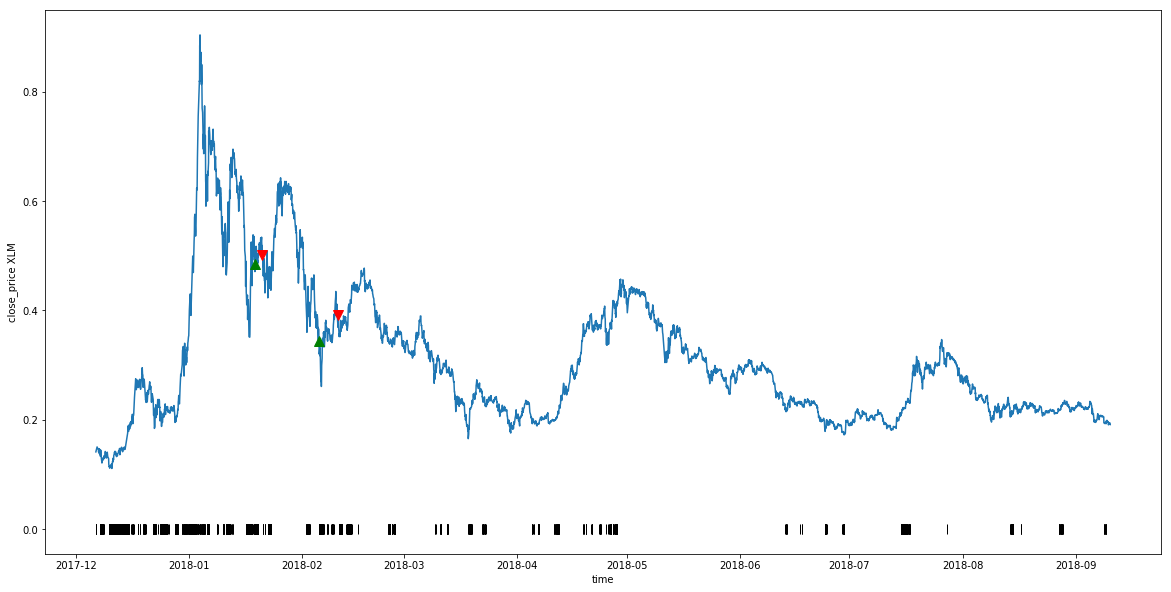

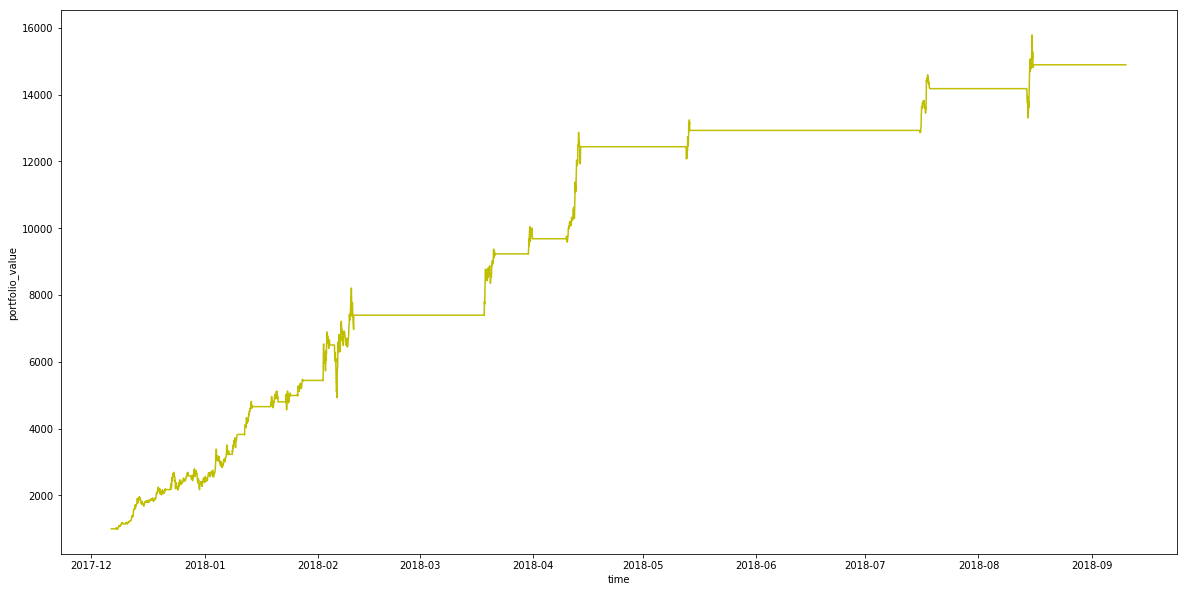

In [6]:
# Training set
threshold = 0.82
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = TradingPair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = TradingPair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'LTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = TradingPair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = TradingPair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = TradingPair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_train_1.index.get_level_values(0).min()
end_date = y_train_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_train_1, trading_pair_2: X_train_2, trading_pair_3: X_train_3, trading_pair_4: X_train_4, trading_pair_5: X_train_5}
X_closes = {trading_pair_1: X_train_close_price_1, trading_pair_2: X_train_close_price_2, trading_pair_3: X_train_close_price_3, trading_pair_4: X_train_close_price_4, trading_pair_5: X_train_close_price_5}

backtest = BacktestingStrategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

[BUY] ORDER PLACED (2018-11-20 09:00:00+00:00): 4982.543640897756 XLM for 1000.0$ (close_price = 0.2$ / fees = 1.0)
[SELL] ORDER PLACED (2018-11-22 03:00:00+00:00): 4982.543640897756 XLM for 983.0683167082296$ (close_price = 0.2$ / fees = 0.98)
[BUY] ORDER PLACED (2018-11-25 00:00:00+00:00): 300.3318802420555 EOS for 983.0683167082296$ (close_price = 3.27$ / fees = 0.98)
[SELL] ORDER PLACED (2018-11-26 01:00:00+00:00): 300.3318802420555 EOS for 1017.1069489465475$ (close_price = 3.39$ / fees = 1.02)
[BUY] ORDER PLACED (2018-11-26 14:00:00+00:00): 7150.526685415911 XLM for 1017.1069489465475$ (close_price = 0.14$ / fees = 1.02)
[SELL] ORDER PLACED (2018-11-28 02:00:00+00:00): 7150.526685415911 XLM for 1077.9354623524318$ (close_price = 0.15$ / fees = 1.08)
[BUY] ORDER PLACED (2018-12-06 20:00:00+00:00): 545.2443174126985 EOS for 1077.9354623524318$ (close_price = 1.98$ / fees = 1.08)
[SELL] ORDER PLACED (2018-12-10 08:00:00+00:00): 545.2443174126985 EOS for 1105.73911838343$ (close_pric

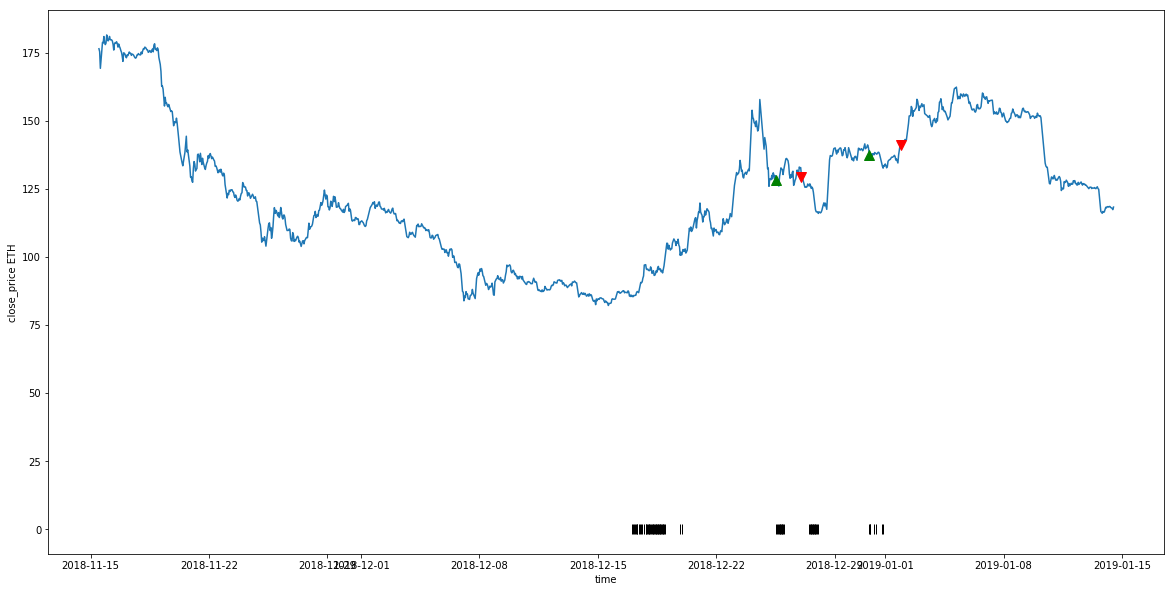

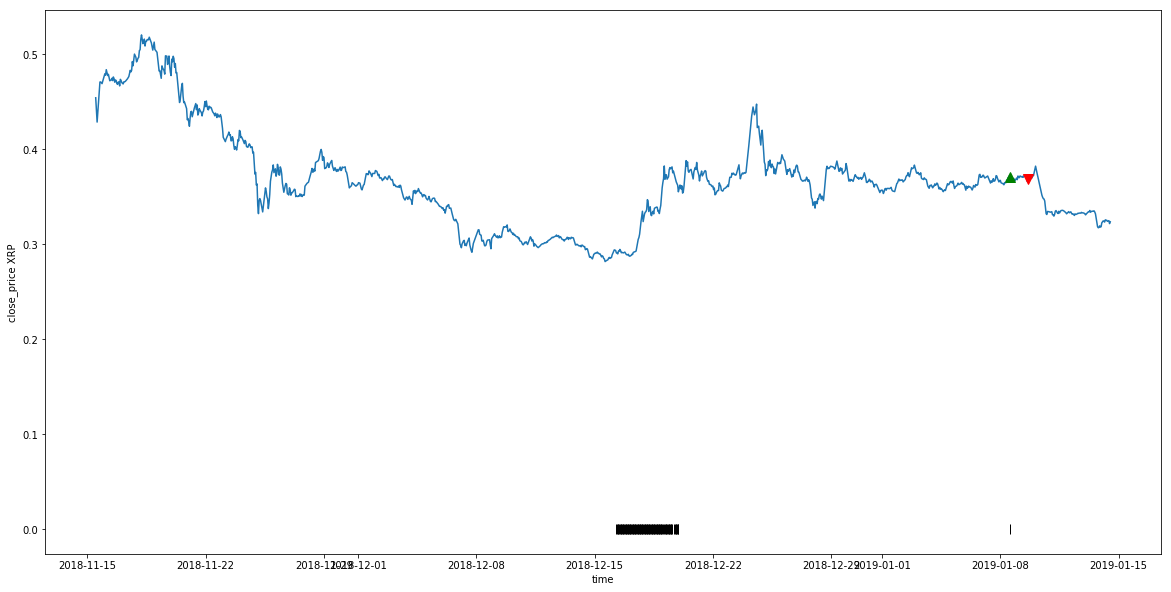

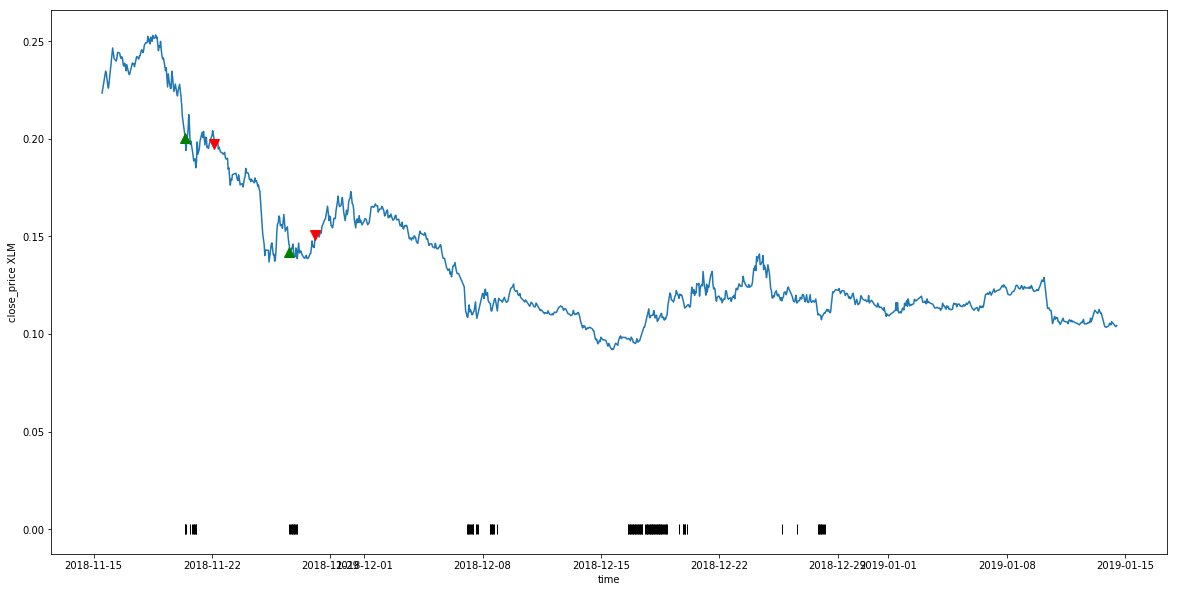

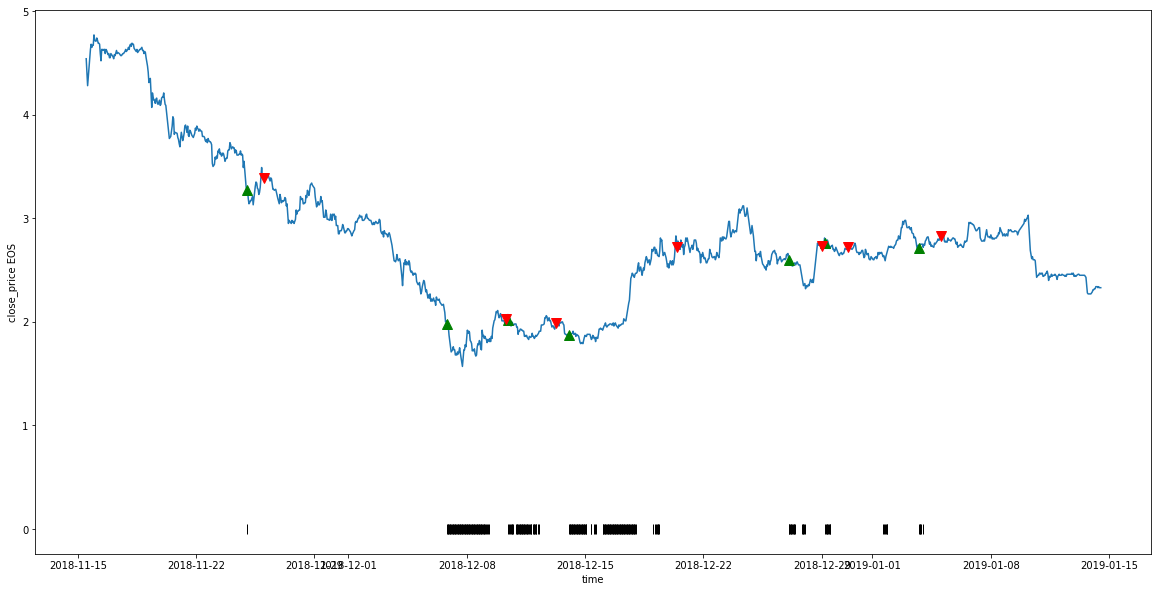

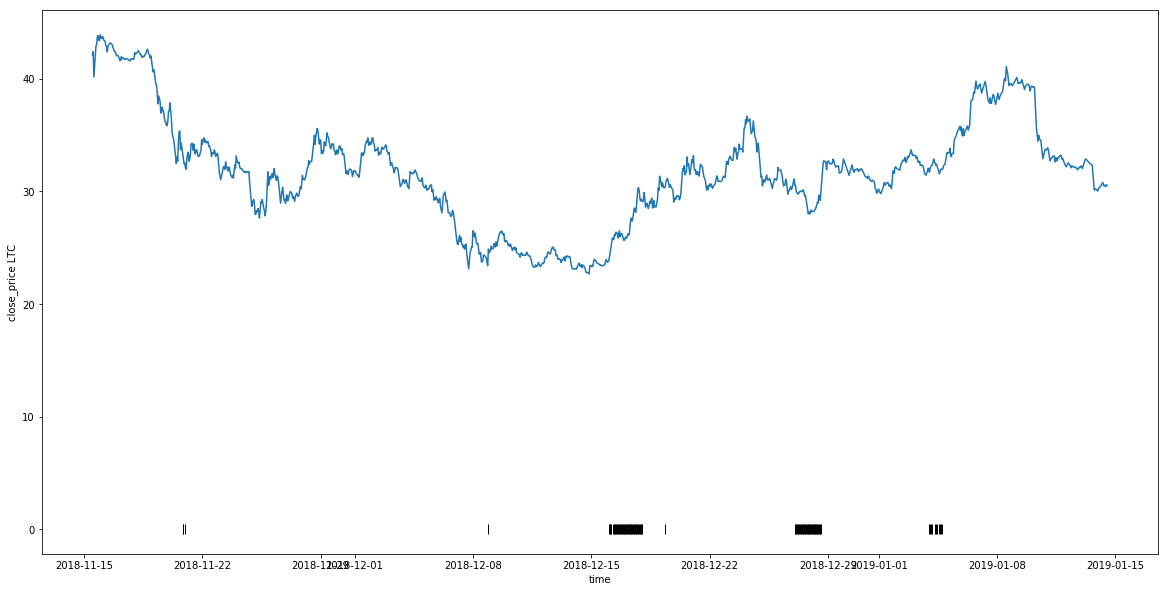

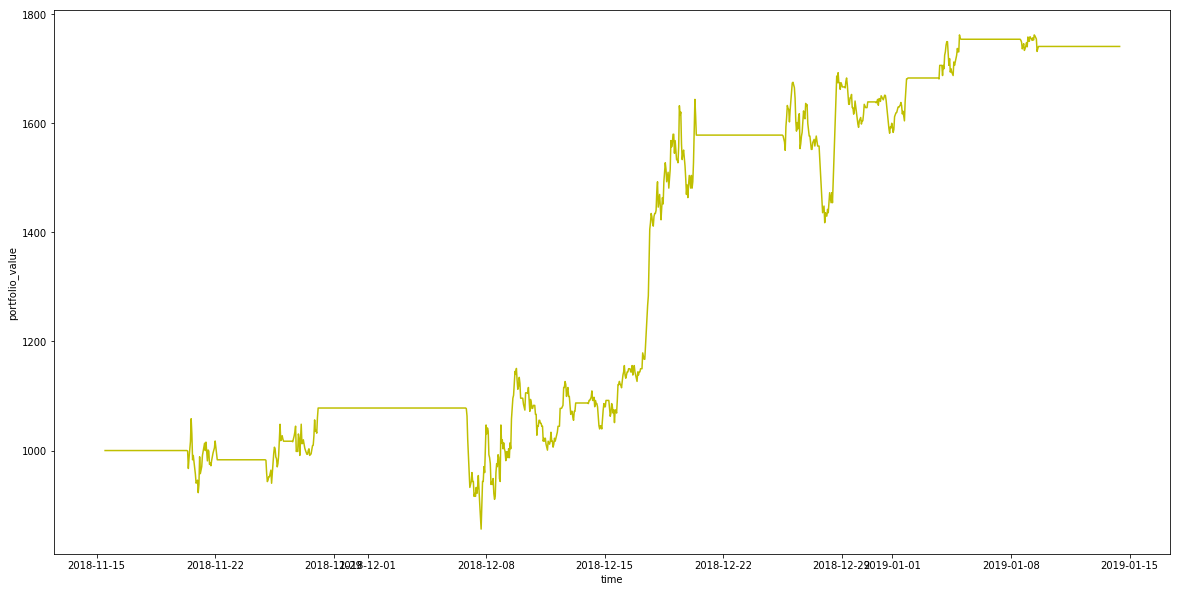

In [3]:
threshold = 0.82
dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
do_scale = True
do_pca = True

init_date = None
end_date = None
cash_asset = 'USDT'

X_tests = {}
X_closes = {}

#dict_df = PreprocLearning.get_global_datasets_for_cryptos(connection, [1182, 7605, 5031, 4614, 166503, 3808, 321992, 5038, 310829, 127356, 3807, 204788], 24)
#dict_df = load_obj('dict_df_2018_01_15_top10')
dict_df = load_obj('dict_df_2018_01_15_topall')



# ===================== EQUIV main Algo avec data from learning + quelques modifs ==============
conf = Config()

# region retrieve algo params
pct_order_placed = float(conf.get_config('trading_module_params', 'pct_order_placed'))
bet_size = float(conf.get_config('trading_module_params', 'bet_size'))
min_bet_size = float(conf.get_config('trading_module_params', 'min_bet_size'))
pct_order_placed = float(conf.get_config('trading_module_params', 'pct_order_placed'))
nb_periods_to_hold_position = int(conf.get_config('trading_module_params', 'nb_periods_to_hold_position'))
cash_asset = conf.get_config('trading_module_params', 'cash_asset')
threshold = float(conf.get_config('trading_module_params', 'threshold'))
trading_assets = conf.parse_config_dict(conf.get_config('trading_module_params', 'trading_assets_all')) # Be careful !
date_to_retrieve_days_to_add = int(conf.get_config('data_params', 'date_to_retrieve_days_to_add'))
model_file_name = conf.get_config('trading_module_params', 'model_file_name')
useless_features_file_name = conf.get_config('trading_module_params', 'useless_features_file_name')
model = load_obj(model_file_name)
useless_features = load_obj(useless_features_file_name)
# endregion Retrieve algo params

# region build trading pairs / tresholds / signals for trading_module usage
trading_pairs = {}
thresholds = {}
signals = {}
dict_last_dates = {}
for id_crypto, binance_symbol in trading_assets.items():
    trading_pair_str = binance_symbol + cash_asset
    trading_pair = TradingPair(trading_pair_str, binance_symbol, cash_asset)
    trading_pairs[trading_pair_str] = trading_pair
    thresholds[trading_pair_str] = threshold

    # retrieve data
    X_train, X_test, y_train, y_test, X_train_close_price, X_test_close_price = PreprocLearning.get_preprocessed_data_learning(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     predict_only_one_crypto,
                                                                     do_scale=do_scale, 
                                                                     do_pca=do_pca,
                                                                     id_cryptocompare=id_crypto,
                                                                     useless_features=useless_features)
    X_train_close_price, X_test_close_price = format_both_close_prices(X_train_close_price, X_test_close_price, id_crypto)
    X_tests[trading_pair_str] = X_test
    X_closes[trading_pair_str] = X_test_close_price    
    
    if init_date is None:
        init_date = y_test.index.get_level_values(0).min()
        end_date = y_test.index.get_level_values(0).max()


model = load_obj('production_model')
backtest = BacktestingStrategy(model, nb_periods_to_hold_position, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, cash_asset)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

In [ ]:
# def train_model(X_, y_):
#     scale_pos_weight = y_.value_counts()[False] / y_.value_counts()[True]
    
# #     xgbc = XGBClassifier(booster='gbtree', colsample_bylevel=1,
# #        colsample_bytree=0.9, gamma=0.0, learning_rate=0.01,
# #        max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
# #        n_estimators=600, nthread=-1,
# #        objective='binary:logistic', random_state=0, reg_alpha=0.01,
# #        reg_lambda=1, scale_pos_weight=4.0270621065611, seed=27,
# #        silent=True, subsample=0.9).fit(X_.values, y_.values)
    
    
# #     xgbc = RandomForestClassifier(bootstrap=False, class_weight='balanced',
# #             criterion='gini', max_depth=5, max_features='sqrt',
# #             max_leaf_nodes=None, min_impurity_decrease=0.0,
# #             min_impurity_split=None, min_samples_leaf=1,
# #             min_samples_split=10, min_weight_fraction_leaf=0.0,
# #             n_estimators=50, oob_score=False, random_state=0,
# #             verbose=0, warm_start=False).fit(X_.values, y_.values)

#     xgbc = XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, silent=True).fit(X_.values, y_.values)
#     return xgbc